# CE-Net


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
import json
import h5py
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from functools import partial


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
nonlinearity = partial(F.relu, inplace=True)

In [5]:
class DACblock(nn.Module):
    def __init__(self, channel):
        super(DACblock, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=3, padding=3)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=5, padding=5)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out


class DACblock_without_atrous(nn.Module):
    def __init__(self, channel):
        super(DACblock_without_atrous, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out

        return out

class DACblock_with_inception(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)

        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(2 * channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate3(self.dilate1(x)))
        dilate_concat = nonlinearity(self.conv1x1(torch.cat([dilate1_out, dilate2_out], 1)))
        dilate3_out = nonlinearity(self.dilate1(dilate_concat))
        out = x + dilate3_out
        return out


class DACblock_with_inception_blocks(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception_blocks, self).__init__()
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        self.conv3x3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv5x5 = nn.Conv2d(channel, channel, kernel_size=5, dilation=1, padding=2)
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.conv1x1(x))
        dilate2_out = nonlinearity(self.conv3x3(self.conv1x1(x)))
        dilate3_out = nonlinearity(self.conv5x5(self.conv1x1(x)))
        dilate4_out = self.pooling(x)
        out = dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out



class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(2, 3, 6, 14)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class SPPblock(nn.Module):
    def __init__(self, in_channels):
        super(SPPblock, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=[3, 3], stride=3)
        self.pool3 = nn.MaxPool2d(kernel_size=[5, 5], stride=5)
        #self.pool4 = nn.MaxPool2d(kernel_size=[6, 6], stride=6)

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        self.in_channels, h, w = x.size(1), x.size(2), x.size(3)
        self.layer1 = F.upsample(self.conv(self.pool1(x)), size=(h, w), mode='bilinear')
        self.layer2 = F.upsample(self.conv(self.pool2(x)), size=(h, w), mode='bilinear')
        self.layer3 = F.upsample(self.conv(self.pool3(x)), size=(h, w), mode='bilinear')
        #self.layer4 = F.upsample(self.conv(self.pool4(x)), size=(h, w), mode='bilinear')

        out = torch.cat([self.layer1, self.layer2, self.layer3, x], 1)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)

        return x

In [6]:
class CE_Net_(nn.Module):
    def __init__(self, num_channels=4, num_classes=5):
        super(CE_Net_, self).__init__()

        filters = [64,128,256,(512+3)]
        resnet = models.resnet34(pretrained=True)
        self.firstconv = nn.Conv2d(num_channels, 64, 7, padding=3)
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dblock = DACblock(512)
        self.spp = SPPblock(512)

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[1], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 10, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dblock(e4)
        e4 = F.upsample(e4,size=(5,5),mode='bilinear')
        e4 = self.spp(e4)

        # Decoder
        d4 = self.decoder4(e4) + F.upsample(e3,size=(10,10),mode='bilinear')
        d3 = self.decoder3(d4) + F.upsample(e2,size=(20,20),mode='bilinear')#e2
        #d2 = self.decoder2(d3) + F.upsample(e1,size=(40,40),mode='bilinear')#e1
        #d1 = self.decoder1(d2)

        out = self.finaldeconv1(d3)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return out

In [7]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [8]:

train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))


In [10]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = CE_Net_(num_channels=4, num_classes=5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

CE_Net_(
  (firstconv): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [11]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_2'):
    os.mkdir('Model_2')
model_save_path = 'Model_2/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

[                                                                        ]N/A% 

Starting epoch 1/100.


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.0000 --- loss: 1.618337


[*************                                                           ] 19% 

0.2000 --- loss: 1.342095


[****************************                                            ] 39% 

0.4000 --- loss: 1.274406


[******************************************                              ] 59% 

0.6000 --- loss: 1.113898


[*********************************************************               ] 79% 

0.8000 --- loss: 1.239554


[                                                                        ]N/A% 

Epoch finished ! Loss: 1.3342341184616089


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 1.1629083156585693
Checkpoint 1 saved !
Starting epoch 2/100.


[                                                                        ]N/A% 

0.0000 --- loss: 1.215697


[*************                                                           ] 19% 

0.2000 --- loss: 1.151205


[****************************                                            ] 39% 

0.4000 --- loss: 1.213452


[******************************************                              ] 59% 

0.6000 --- loss: 1.045758


[*********************************************************               ] 79% 

0.8000 --- loss: 1.032155


[                                                                        ]N/A% 

Epoch finished ! Loss: 1.090538740158081


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.9397064447402954
Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 0.835290


[*************                                                           ] 19% 

0.2000 --- loss: 1.000237


[****************************                                            ] 39% 

0.4000 --- loss: 0.880533


[******************************************                              ] 59% 

0.6000 --- loss: 0.745990


[*********************************************************               ] 79% 

0.8000 --- loss: 0.793618


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.8971685767173767


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.9146832227706909
Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.980845


[*************                                                           ] 19% 

0.2000 --- loss: 0.797069


[****************************                                            ] 39% 

0.4000 --- loss: 0.898129


[******************************************                              ] 59% 

0.6000 --- loss: 0.888045


[*********************************************************               ] 79% 

0.8000 --- loss: 0.825157


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.8108018040657043


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.7574312090873718
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.849602


[*************                                                           ] 19% 

0.2000 --- loss: 0.843081


[****************************                                            ] 39% 

0.4000 --- loss: 0.730810


[******************************************                              ] 59% 

0.6000 --- loss: 0.758947


[*********************************************************               ] 79% 

0.8000 --- loss: 0.639444


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.7309741973876953


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6890155076980591
Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.644118


[*************                                                           ] 19% 

0.2000 --- loss: 0.660316


[****************************                                            ] 39% 

0.4000 --- loss: 0.650885


[******************************************                              ] 59% 

0.6000 --- loss: 0.676900


[*********************************************************               ] 79% 

0.8000 --- loss: 0.738930


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6965242624282837


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.661365807056427


[                                                                        ]N/A% 

Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.623519


[*************                                                           ] 19% 

0.2000 --- loss: 0.772523


[****************************                                            ] 39% 

0.4000 --- loss: 0.589179


[******************************************                              ] 59% 

0.6000 --- loss: 0.611331


[*********************************************************               ] 79% 

0.8000 --- loss: 0.683301


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6632067561149597


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6215375661849976
Checkpoint 7 saved !
Starting epoch 8/100.
0.0000 --- loss: 0.681982


[*************                                                           ] 19% 

0.2000 --- loss: 0.560587


[****************************                                            ] 39% 

0.4000 --- loss: 0.571101


[******************************************                              ] 59% 

0.6000 --- loss: 0.603699


[*********************************************************               ] 79% 

0.8000 --- loss: 0.607746


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6363710165023804


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6413861513137817
Checkpoint 8 saved !
Starting epoch 9/100.
0.0000 --- loss: 0.693911


[*************                                                           ] 19% 

0.2000 --- loss: 0.584439


[****************************                                            ] 39% 

0.4000 --- loss: 0.632489


[******************************************                              ] 59% 

0.6000 --- loss: 0.649599


[*********************************************************               ] 79% 

0.8000 --- loss: 0.597633


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6312862634658813


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6110265254974365
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.605528


[*************                                                           ] 19% 

0.2000 --- loss: 0.540703


[****************************                                            ] 39% 

0.4000 --- loss: 0.598304


[******************************************                              ] 59% 

0.6000 --- loss: 0.588586


[*********************************************************               ] 79% 

0.8000 --- loss: 0.607582


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6085259914398193


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6008456945419312
Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.469835


[*************                                                           ] 19% 

0.2000 --- loss: 0.705348


[****************************                                            ] 39% 

0.4000 --- loss: 0.576375


[******************************************                              ] 59% 

0.6000 --- loss: 0.554338


[*********************************************************               ] 79% 

0.8000 --- loss: 0.858897


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.600822925567627


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6136612892150879
Checkpoint 11 saved !
Starting epoch 12/100.
0.0000 --- loss: 0.563231


[*************                                                           ] 19% 

0.2000 --- loss: 0.535165


[****************************                                            ] 39% 

0.4000 --- loss: 0.618478


[******************************************                              ] 59% 

0.6000 --- loss: 0.560792


[*********************************************************               ] 79% 

0.8000 --- loss: 0.560783


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5963365435600281


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6049625873565674
Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.528833


[*************                                                           ] 19% 

0.2000 --- loss: 0.616769


[****************************                                            ] 39% 

0.4000 --- loss: 0.549359


[******************************************                              ] 59% 

0.6000 --- loss: 0.562773


[*********************************************************               ] 79% 

0.8000 --- loss: 0.551909


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5706179738044739


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.6404070854187012


[                                                                        ]N/A% 

Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.629087


[*************                                                           ] 19% 

0.2000 --- loss: 0.610792


[****************************                                            ] 39% 

0.4000 --- loss: 0.542932


[******************************************                              ] 59% 

0.6000 --- loss: 0.540919


[*********************************************************               ] 79% 

0.8000 --- loss: 0.606815


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5707687735557556


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6429746150970459
Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.603923


[*************                                                           ] 19% 

0.2000 --- loss: 0.586629


[****************************                                            ] 39% 

0.4000 --- loss: 0.597893


[******************************************                              ] 59% 

0.6000 --- loss: 0.554314


[*********************************************************               ] 79% 

0.8000 --- loss: 0.516059


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5498077869415283


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5744478702545166
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.469452


[*************                                                           ] 19% 

0.2000 --- loss: 0.745591


[****************************                                            ] 39% 

0.4000 --- loss: 0.564344


[******************************************                              ] 59% 

0.6000 --- loss: 0.461338


[*********************************************************               ] 79% 

0.8000 --- loss: 0.512714


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5429564118385315


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5878523588180542
Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.488578


[*************                                                           ] 19% 

0.2000 --- loss: 0.560130


[****************************                                            ] 39% 

0.4000 --- loss: 0.568386


[******************************************                              ] 59% 

0.6000 --- loss: 0.463971


[*********************************************************               ] 79% 

0.8000 --- loss: 0.562145


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5428241491317749


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6638330221176147
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.422543


[*************                                                           ] 19% 

0.2000 --- loss: 0.579215


[****************************                                            ] 39% 

0.4000 --- loss: 0.593487


[******************************************                              ] 59% 

0.6000 --- loss: 0.515576


[*********************************************************               ] 79% 

0.8000 --- loss: 0.503210


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5291217565536499


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5704442262649536
Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.437404


[*************                                                           ] 19% 

0.2000 --- loss: 0.555639


[****************************                                            ] 39% 

0.4000 --- loss: 0.545492


[******************************************                              ] 59% 

0.6000 --- loss: 0.542564


[*********************************************************               ] 79% 

0.8000 --- loss: 0.438346


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5159469842910767


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5701499581336975
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.461612


[*************                                                           ] 19% 

0.2000 --- loss: 0.473960


[****************************                                            ] 39% 

0.4000 --- loss: 0.484789


[******************************************                              ] 59% 

0.6000 --- loss: 0.444344


[*********************************************************               ] 79% 

0.8000 --- loss: 0.498198


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.513220489025116


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5654911398887634
Checkpoint 20 saved !
Starting epoch 21/100.
0.0000 --- loss: 0.601565


[*************                                                           ] 19% 

0.2000 --- loss: 0.488137


[****************************                                            ] 39% 

0.4000 --- loss: 0.490095


[******************************************                              ] 59% 

0.6000 --- loss: 0.470316


[*********************************************************               ] 79% 

0.8000 --- loss: 0.472753


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5072932243347168


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6016690731048584
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.550690


[*************                                                           ] 19% 

0.2000 --- loss: 0.440691


[****************************                                            ] 39% 

0.4000 --- loss: 0.570175


[******************************************                              ] 59% 

0.6000 --- loss: 0.444772


[*********************************************************               ] 79% 

0.8000 --- loss: 0.443991


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.4980997145175934


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5775552988052368
Checkpoint 22 saved !
Starting epoch 23/100.
0.0000 --- loss: 0.452854


[*************                                                           ] 19% 

0.2000 --- loss: 0.512339


[****************************                                            ] 39% 

0.4000 --- loss: 0.537608


[******************************************                              ] 59% 

0.6000 --- loss: 0.485459


[*********************************************************               ] 79% 

0.8000 --- loss: 0.523355


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.49117511510849


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5684535503387451
Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.560985


[*************                                                           ] 19% 

0.2000 --- loss: 0.512225


[****************************                                            ] 39% 

0.4000 --- loss: 0.491493


[******************************************                              ] 59% 

0.6000 --- loss: 0.485442


[*********************************************************               ] 79% 

0.8000 --- loss: 0.492893


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4818025827407837


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5640151500701904
Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.416527


[*************                                                           ] 19% 

0.2000 --- loss: 0.515271


[****************************                                            ] 39% 

0.4000 --- loss: 0.424733


[******************************************                              ] 59% 

0.6000 --- loss: 0.518304


[*********************************************************               ] 79% 

0.8000 --- loss: 0.486242


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.48172685503959656


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5959221124649048
Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.452992


[*************                                                           ] 19% 

0.2000 --- loss: 0.398108


[****************************                                            ] 39% 

0.4000 --- loss: 0.429780


[******************************************                              ] 59% 

0.6000 --- loss: 0.496517


[*********************************************************               ] 79% 

0.8000 --- loss: 0.447847


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.46838730573654175


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5688489079475403
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.544580


[*************                                                           ] 19% 

0.2000 --- loss: 0.426259


[****************************                                            ] 39% 

0.4000 --- loss: 0.421250


[******************************************                              ] 59% 

0.6000 --- loss: 0.447282


[*********************************************************               ] 79% 

0.8000 --- loss: 0.460397


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4645317792892456


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5794023871421814
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.468458


[*************                                                           ] 19% 

0.2000 --- loss: 0.444360


[****************************                                            ] 39% 

0.4000 --- loss: 0.391530


[******************************************                              ] 59% 

0.6000 --- loss: 0.523028


[*********************************************************               ] 79% 

0.8000 --- loss: 0.374286


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.466413676738739


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5547884106636047
Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.395685


[*************                                                           ] 19% 

0.2000 --- loss: 0.467008


[****************************                                            ] 39% 

0.4000 --- loss: 0.408193


[******************************************                              ] 59% 

0.6000 --- loss: 0.406387


[*********************************************************               ] 79% 

0.8000 --- loss: 0.488620


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.45657896995544434


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5608885884284973
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.444966


[*************                                                           ] 19% 

0.2000 --- loss: 0.391700


[****************************                                            ] 39% 

0.4000 --- loss: 0.446863


[******************************************                              ] 59% 

0.6000 --- loss: 0.363113


[*********************************************************               ] 79% 

0.8000 --- loss: 0.387649


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.44987720251083374


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5709726810455322
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.442608


[*************                                                           ] 19% 

0.2000 --- loss: 0.398497


[****************************                                            ] 39% 

0.4000 --- loss: 0.355772


[******************************************                              ] 59% 

0.6000 --- loss: 0.446253


[*********************************************************               ] 79% 

0.8000 --- loss: 0.430518


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.44722652435302734


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5551589727401733
Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.340986


[*************                                                           ] 19% 

0.2000 --- loss: 0.435223


[****************************                                            ] 39% 

0.4000 --- loss: 0.422062


[******************************************                              ] 59% 

0.6000 --- loss: 0.581560


[*********************************************************               ] 79% 

0.8000 --- loss: 0.436640


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.44861000776290894


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.594473659992218
Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.432196


[*************                                                           ] 19% 

0.2000 --- loss: 0.445706


[****************************                                            ] 39% 

0.4000 --- loss: 0.416359


[******************************************                              ] 59% 

0.6000 --- loss: 0.507242


[*********************************************************               ] 79% 

0.8000 --- loss: 0.438631


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4425209164619446


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5674097537994385
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.513043


[*************                                                           ] 19% 

0.2000 --- loss: 0.445387


[****************************                                            ] 39% 

0.4000 --- loss: 0.404549


[******************************************                              ] 59% 

0.6000 --- loss: 0.437114


[*********************************************************               ] 79% 

0.8000 --- loss: 0.487628


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.43753013014793396


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.576138436794281
Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.409467


[*************                                                           ] 19% 

0.2000 --- loss: 0.520098


[****************************                                            ] 39% 

0.4000 --- loss: 0.441438


[******************************************                              ] 59% 

0.6000 --- loss: 0.538898


[*********************************************************               ] 79% 

0.8000 --- loss: 0.479250


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4317280948162079


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5677719116210938
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.429058


[*************                                                           ] 19% 

0.2000 --- loss: 0.459413


[****************************                                            ] 39% 

0.4000 --- loss: 0.440368


[******************************************                              ] 59% 

0.6000 --- loss: 0.428909


[*********************************************************               ] 79% 

0.8000 --- loss: 0.381548


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4252224862575531


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5846017599105835
Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.383436


[*************                                                           ] 19% 

0.2000 --- loss: 0.462783


[****************************                                            ] 39% 

0.4000 --- loss: 0.463224


[******************************************                              ] 59% 

0.6000 --- loss: 0.419891


[*********************************************************               ] 79% 

0.8000 --- loss: 0.430386


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.42245742678642273


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5701395869255066
Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.419243


[*************                                                           ] 19% 

0.2000 --- loss: 0.570675


[****************************                                            ] 39% 

0.4000 --- loss: 0.372087


[******************************************                              ] 59% 

0.6000 --- loss: 0.329824


[*********************************************************               ] 79% 

0.8000 --- loss: 0.412759


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.42533349990844727


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5866661071777344
Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.374038


[*************                                                           ] 19% 

0.2000 --- loss: 0.535496


[****************************                                            ] 39% 

0.4000 --- loss: 0.419535


[******************************************                              ] 59% 

0.6000 --- loss: 0.398718


[*********************************************************               ] 79% 

0.8000 --- loss: 0.425898


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4201967716217041


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5640910863876343
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.408875


[*************                                                           ] 19% 

0.2000 --- loss: 0.418994


[****************************                                            ] 39% 

0.4000 --- loss: 0.444449


[******************************************                              ] 59% 

0.6000 --- loss: 0.343210


[*********************************************************               ] 79% 

0.8000 --- loss: 0.400077


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.41693854331970215


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.575961709022522
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.488774


[*************                                                           ] 19% 

0.2000 --- loss: 0.368571


[****************************                                            ] 39% 

0.4000 --- loss: 0.360417


[******************************************                              ] 59% 

0.6000 --- loss: 0.419497


[*********************************************************               ] 79% 

0.8000 --- loss: 0.454151


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4125625193119049


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5622698664665222
Checkpoint 41 saved !
Starting epoch 42/100.
0.0000 --- loss: 0.411545


[*************                                                           ] 19% 

0.2000 --- loss: 0.367160


[****************************                                            ] 39% 

0.4000 --- loss: 0.396488


[******************************************                              ] 59% 

0.6000 --- loss: 0.387038


[*********************************************************               ] 79% 

0.8000 --- loss: 0.371834


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4093990623950958


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5601679682731628
Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.394573


[*************                                                           ] 19% 

0.2000 --- loss: 0.343887


[****************************                                            ] 39% 

0.4000 --- loss: 0.394860


[******************************************                              ] 59% 

0.6000 --- loss: 0.426893


[*********************************************************               ] 79% 

0.8000 --- loss: 0.388211


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4063197672367096


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5653594732284546
Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.448227


[*************                                                           ] 19% 

0.2000 --- loss: 0.379441


[****************************                                            ] 39% 

0.4000 --- loss: 0.422512


[******************************************                              ] 59% 

0.6000 --- loss: 0.441001


[*********************************************************               ] 79% 

0.8000 --- loss: 0.382879


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4018612205982208


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5723506212234497
Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.388959


[*************                                                           ] 19% 

0.2000 --- loss: 0.392469


[****************************                                            ] 39% 

0.4000 --- loss: 0.421411


[******************************************                              ] 59% 

0.6000 --- loss: 0.373851


[*********************************************************               ] 79% 

0.8000 --- loss: 0.476429


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4033862054347992


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5888180136680603
Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.375443


[*************                                                           ] 19% 

0.2000 --- loss: 0.459727


[****************************                                            ] 39% 

0.4000 --- loss: 0.380193


[******************************************                              ] 59% 

0.6000 --- loss: 0.358161


[*********************************************************               ] 79% 

0.8000 --- loss: 0.393072


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.40069589018821716


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5640788078308105
Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.343936


[*************                                                           ] 19% 

0.2000 --- loss: 0.376606


[****************************                                            ] 39% 

0.4000 --- loss: 0.348815


[******************************************                              ] 59% 

0.6000 --- loss: 0.327921


[*********************************************************               ] 79% 

0.8000 --- loss: 0.415698


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3927949368953705


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5746934413909912
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.349427


[*************                                                           ] 19% 

0.2000 --- loss: 0.363450


[****************************                                            ] 39% 

0.4000 --- loss: 0.471973


[******************************************                              ] 59% 

0.6000 --- loss: 0.436449


[*********************************************************               ] 79% 

0.8000 --- loss: 0.416331


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3995048701763153


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5530834197998047
Checkpoint 48 saved !
Starting epoch 49/100.
0.0000 --- loss: 0.386222


[*************                                                           ] 19% 

0.2000 --- loss: 0.350542


[****************************                                            ] 39% 

0.4000 --- loss: 0.387096


[******************************************                              ] 59% 

0.6000 --- loss: 0.322047


[*********************************************************               ] 79% 

0.8000 --- loss: 0.372262


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.39253339171409607


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5911328792572021
Checkpoint 49 saved !
Starting epoch 50/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.438897


[*************                                                           ] 19% 

0.2000 --- loss: 0.398232


[****************************                                            ] 39% 

0.4000 --- loss: 0.355851


[******************************************                              ] 59% 

0.6000 --- loss: 0.375226


[*********************************************************               ] 79% 

0.8000 --- loss: 0.359962


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3914468288421631


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5594530701637268
Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.336628


[*************                                                           ] 19% 

0.2000 --- loss: 0.415268


[****************************                                            ] 39% 

0.4000 --- loss: 0.427612


[******************************************                              ] 59% 

0.6000 --- loss: 0.410004


[*********************************************************               ] 79% 

0.8000 --- loss: 0.366054


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3947438597679138


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5620200634002686
Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.378807


[*************                                                           ] 19% 

0.2000 --- loss: 0.404028


[****************************                                            ] 39% 

0.4000 --- loss: 0.378973


[******************************************                              ] 59% 

0.6000 --- loss: 0.382246


[*********************************************************               ] 79% 

0.8000 --- loss: 0.335249


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3884453773498535


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5613742470741272
Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.353278


[*************                                                           ] 19% 

0.2000 --- loss: 0.348298


[****************************                                            ] 39% 

0.4000 --- loss: 0.313896


[******************************************                              ] 59% 

0.6000 --- loss: 0.361776


[*********************************************************               ] 79% 

0.8000 --- loss: 0.444788


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.38694238662719727


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5686842203140259
Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.418820


[*************                                                           ] 19% 

0.2000 --- loss: 0.422593


[****************************                                            ] 39% 

0.4000 --- loss: 0.489046


[******************************************                              ] 59% 

0.6000 --- loss: 0.302343


[*********************************************************               ] 79% 

0.8000 --- loss: 0.382158


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3854880928993225


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5683996677398682
Checkpoint 54 saved !
Starting epoch 55/100.
0.0000 --- loss: 0.361590


[*************                                                           ] 19% 

0.2000 --- loss: 0.316823


[****************************                                            ] 39% 

0.4000 --- loss: 0.426578


[******************************************                              ] 59% 

0.6000 --- loss: 0.365842


[*********************************************************               ] 79% 

0.8000 --- loss: 0.327903


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.37554818391799927


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5776855945587158
Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.395663


[*************                                                           ] 19% 

0.2000 --- loss: 0.303168


[****************************                                            ] 39% 

0.4000 --- loss: 0.392858


[******************************************                              ] 59% 

0.6000 --- loss: 0.326861


[*********************************************************               ] 79% 

0.8000 --- loss: 0.363857


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3763750493526459


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5611927509307861
Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.369238


[*************                                                           ] 19% 

0.2000 --- loss: 0.415254


[****************************                                            ] 39% 

0.4000 --- loss: 0.422926


[******************************************                              ] 59% 

0.6000 --- loss: 0.336884


[*********************************************************               ] 79% 

0.8000 --- loss: 0.351715


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3753930926322937


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5954900979995728
Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.377125


[*************                                                           ] 19% 

0.2000 --- loss: 0.419118


[****************************                                            ] 39% 

0.4000 --- loss: 0.331589


[******************************************                              ] 59% 

0.6000 --- loss: 0.353479


[*********************************************************               ] 79% 

0.8000 --- loss: 0.379102


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3745959401130676


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.569551944732666
Checkpoint 58 saved !
Starting epoch 59/100.
0.0000 --- loss: 0.417699


[*************                                                           ] 19% 

0.2000 --- loss: 0.403205


[****************************                                            ] 39% 

0.4000 --- loss: 0.332266


[******************************************                              ] 59% 

0.6000 --- loss: 0.365240


[*********************************************************               ] 79% 

0.8000 --- loss: 0.440703


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.37532123923301697


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5705480575561523
Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.374447


[*************                                                           ] 19% 

0.2000 --- loss: 0.345034


[****************************                                            ] 39% 

0.4000 --- loss: 0.327173


[******************************************                              ] 59% 

0.6000 --- loss: 0.319263


[*********************************************************               ] 79% 

0.8000 --- loss: 0.390556


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.37491413950920105


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5656666159629822
Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.448958


[*************                                                           ] 19% 

0.2000 --- loss: 0.283356


[****************************                                            ] 39% 

0.4000 --- loss: 0.337439


[******************************************                              ] 59% 

0.6000 --- loss: 0.343956


[*********************************************************               ] 79% 

0.8000 --- loss: 0.387018


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.377381831407547


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5715708136558533
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.318261


[*************                                                           ] 19% 

0.2000 --- loss: 0.437013


[****************************                                            ] 39% 

0.4000 --- loss: 0.379916


[******************************************                              ] 59% 

0.6000 --- loss: 0.319215


[*********************************************************               ] 79% 

0.8000 --- loss: 0.344914


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.36778169870376587


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5717458128929138
Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.375124


[*************                                                           ] 19% 

0.2000 --- loss: 0.337183


[****************************                                            ] 39% 

0.4000 --- loss: 0.328953


[******************************************                              ] 59% 

0.6000 --- loss: 0.335192


[*********************************************************               ] 79% 

0.8000 --- loss: 0.314666


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3626660406589508


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5758917331695557
Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.350507


[*************                                                           ] 19% 

0.2000 --- loss: 0.390209


[****************************                                            ] 39% 

0.4000 --- loss: 0.354200


[******************************************                              ] 59% 

0.6000 --- loss: 0.350672


[*********************************************************               ] 79% 

0.8000 --- loss: 0.467767


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.36519190669059753


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5692613124847412
Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.346900


[*************                                                           ] 19% 

0.2000 --- loss: 0.345960


[****************************                                            ] 39% 

0.4000 --- loss: 0.349535


[******************************************                              ] 59% 

0.6000 --- loss: 0.394768


[*********************************************************               ] 79% 

0.8000 --- loss: 0.293099


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3594876229763031


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5712945461273193
Checkpoint 65 saved !
Starting epoch 66/100.
0.0000 --- loss: 0.303172


[*************                                                           ] 19% 

0.2000 --- loss: 0.342786


[****************************                                            ] 39% 

0.4000 --- loss: 0.364006


[******************************************                              ] 59% 

0.6000 --- loss: 0.424317


[*********************************************************               ] 79% 

0.8000 --- loss: 0.372640


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3585001230239868


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.572563111782074
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.361652


[*************                                                           ] 19% 

0.2000 --- loss: 0.301356


[****************************                                            ] 39% 

0.4000 --- loss: 0.339132


[******************************************                              ] 59% 

0.6000 --- loss: 0.367413


[*********************************************************               ] 79% 

0.8000 --- loss: 0.363981


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3572257459163666


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5651596784591675
Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.311501


[*************                                                           ] 19% 

0.2000 --- loss: 0.425902


[****************************                                            ] 39% 

0.4000 --- loss: 0.342848


[******************************************                              ] 59% 

0.6000 --- loss: 0.377264


[*********************************************************               ] 79% 

0.8000 --- loss: 0.333516


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3568953573703766


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5644741654396057
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.360106


[*************                                                           ] 19% 

0.2000 --- loss: 0.330657


[****************************                                            ] 39% 

0.4000 --- loss: 0.301209


[******************************************                              ] 59% 

0.6000 --- loss: 0.315205


[*********************************************************               ] 79% 

0.8000 --- loss: 0.308457


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3564372658729553


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5685192942619324
Checkpoint 69 saved !
Starting epoch 70/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.390418


[*************                                                           ] 19% 

0.2000 --- loss: 0.325618


[****************************                                            ] 39% 

0.4000 --- loss: 0.334998


[******************************************                              ] 59% 

0.6000 --- loss: 0.321670


[*********************************************************               ] 79% 

0.8000 --- loss: 0.438564


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35769572854042053


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5657368302345276
Checkpoint 70 saved !
Starting epoch 71/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.338906


[*************                                                           ] 19% 

0.2000 --- loss: 0.308178


[****************************                                            ] 39% 

0.4000 --- loss: 0.370630


[******************************************                              ] 59% 

0.6000 --- loss: 0.399988


[*********************************************************               ] 79% 

0.8000 --- loss: 0.356704


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35849565267562866


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5625477433204651
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.297573


[*************                                                           ] 19% 

0.2000 --- loss: 0.303189


[****************************                                            ] 39% 

0.4000 --- loss: 0.377746


[******************************************                              ] 59% 

0.6000 --- loss: 0.336244


[*********************************************************               ] 79% 

0.8000 --- loss: 0.295163


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3523644804954529


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5746372938156128
Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.355331


[*************                                                           ] 19% 

0.2000 --- loss: 0.324391


[****************************                                            ] 39% 

0.4000 --- loss: 0.375551


[******************************************                              ] 59% 

0.6000 --- loss: 0.355470


[*********************************************************               ] 79% 

0.8000 --- loss: 0.436826


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34841182827949524


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6047648191452026
Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.336003


[*************                                                           ] 19% 

0.2000 --- loss: 0.339807


[****************************                                            ] 39% 

0.4000 --- loss: 0.300286


[******************************************                              ] 59% 

0.6000 --- loss: 0.340425


[*********************************************************               ] 79% 

0.8000 --- loss: 0.370345


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35048529505729675


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5808890461921692


[                                                                        ]N/A% 

Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.385430


[*************                                                           ] 19% 

0.2000 --- loss: 0.317294


[****************************                                            ] 39% 

0.4000 --- loss: 0.354272


[******************************************                              ] 59% 

0.6000 --- loss: 0.379428


[*********************************************************               ] 79% 

0.8000 --- loss: 0.355700


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34456565976142883


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5763870477676392
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.342801


[*************                                                           ] 19% 

0.2000 --- loss: 0.330545


[****************************                                            ] 39% 

0.4000 --- loss: 0.348079


[******************************************                              ] 59% 

0.6000 --- loss: 0.354322


[*********************************************************               ] 79% 

0.8000 --- loss: 0.311886


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3449012041091919


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5768731832504272
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.301778


[*************                                                           ] 19% 

0.2000 --- loss: 0.302176


[****************************                                            ] 39% 

0.4000 --- loss: 0.360120


[******************************************                              ] 59% 

0.6000 --- loss: 0.323081


[*********************************************************               ] 79% 

0.8000 --- loss: 0.368707


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3465449810028076


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5764293074607849
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.330394


[*************                                                           ] 19% 

0.2000 --- loss: 0.358723


[****************************                                            ] 39% 

0.4000 --- loss: 0.297624


[******************************************                              ] 59% 

0.6000 --- loss: 0.346789


[*********************************************************               ] 79% 

0.8000 --- loss: 0.314422


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.349086731672287


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5819303393363953
Checkpoint 78 saved !
Starting epoch 79/100.
0.0000 --- loss: 0.315383


[*************                                                           ] 19% 

0.2000 --- loss: 0.367307


[****************************                                            ] 39% 

0.4000 --- loss: 0.315388


[******************************************                              ] 59% 

0.6000 --- loss: 0.353392


[*********************************************************               ] 79% 

0.8000 --- loss: 0.277788


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3408818244934082


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5813062787055969
Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.305571


[*************                                                           ] 19% 

0.2000 --- loss: 0.314443


[****************************                                            ] 39% 

0.4000 --- loss: 0.324466


[******************************************                              ] 59% 

0.6000 --- loss: 0.353422


[*********************************************************               ] 79% 

0.8000 --- loss: 0.360879


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.33969444036483765


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5805199146270752
Checkpoint 80 saved !
Starting epoch 81/100.
0.0000 --- loss: 0.348731


[*************                                                           ] 19% 

0.2000 --- loss: 0.390660


[****************************                                            ] 39% 

0.4000 --- loss: 0.419466


[******************************************                              ] 59% 

0.6000 --- loss: 0.361029


[*********************************************************               ] 79% 

0.8000 --- loss: 0.363815


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3351198732852936


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.597052812576294
Checkpoint 81 saved !
Starting epoch 82/100.
0.0000 --- loss: 0.359082


[*************                                                           ] 19% 

0.2000 --- loss: 0.291501


[****************************                                            ] 39% 

0.4000 --- loss: 0.312682


[******************************************                              ] 59% 

0.6000 --- loss: 0.307715


[*********************************************************               ] 79% 

0.8000 --- loss: 0.335706


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3360748589038849


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5781564116477966
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.382833


[*************                                                           ] 19% 

0.2000 --- loss: 0.335334


[****************************                                            ] 39% 

0.4000 --- loss: 0.332283


[******************************************                              ] 59% 

0.6000 --- loss: 0.329083


[*********************************************************               ] 79% 

0.8000 --- loss: 0.306437


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.338837593793869


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5684000849723816
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.367195


[*************                                                           ] 19% 

0.2000 --- loss: 0.327160


[****************************                                            ] 39% 

0.4000 --- loss: 0.337177


[******************************************                              ] 59% 

0.6000 --- loss: 0.350457


[*********************************************************               ] 79% 

0.8000 --- loss: 0.266372


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3335348069667816


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5725334882736206
Checkpoint 84 saved !
Starting epoch 85/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.373591


[*************                                                           ] 19% 

0.2000 --- loss: 0.320106


[****************************                                            ] 39% 

0.4000 --- loss: 0.318076


[******************************************                              ] 59% 

0.6000 --- loss: 0.301022


[*********************************************************               ] 79% 

0.8000 --- loss: 0.385005


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.329121470451355


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5729354023933411
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.413832


[*************                                                           ] 19% 

0.2000 --- loss: 0.336320


[****************************                                            ] 39% 

0.4000 --- loss: 0.362588


[******************************************                              ] 59% 

0.6000 --- loss: 0.331264


[*********************************************************               ] 79% 

0.8000 --- loss: 0.307839


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.329884797334671


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5947098731994629
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.358933


[*************                                                           ] 19% 

0.2000 --- loss: 0.317987


[****************************                                            ] 39% 

0.4000 --- loss: 0.299269


[******************************************                              ] 59% 

0.6000 --- loss: 0.295089


[*********************************************************               ] 79% 

0.8000 --- loss: 0.319891


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.33049601316452026


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5663591623306274
Checkpoint 87 saved !

[                                                                        ]N/A% 


Starting epoch 88/100.
0.0000 --- loss: 0.342001


[*************                                                           ] 19% 

0.2000 --- loss: 0.353700


[****************************                                            ] 39% 

0.4000 --- loss: 0.376473


[******************************************                              ] 59% 

0.6000 --- loss: 0.361494


[*********************************************************               ] 79% 

0.8000 --- loss: 0.333444


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3325212299823761


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5715752840042114
Checkpoint 88 saved !
Starting epoch 89/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.304281


[*************                                                           ] 19% 

0.2000 --- loss: 0.324466


[****************************                                            ] 39% 

0.4000 --- loss: 0.377284


[******************************************                              ] 59% 

0.6000 --- loss: 0.323549


[*********************************************************               ] 79% 

0.8000 --- loss: 0.303374


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3332323431968689


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5747457146644592
Checkpoint 89 saved !
Starting epoch 90/100.
0.0000 --- loss: 0.272122


[*************                                                           ] 19% 

0.2000 --- loss: 0.305523


[****************************                                            ] 39% 

0.4000 --- loss: 0.382398


[******************************************                              ] 59% 

0.6000 --- loss: 0.388254


[*********************************************************               ] 79% 

0.8000 --- loss: 0.339900


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32995232939720154


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.577698290348053
Checkpoint 90 saved !
Starting epoch 91/100.
0.0000 --- loss: 0.360319


[*************                                                           ] 19% 

0.2000 --- loss: 0.334504


[****************************                                            ] 39% 

0.4000 --- loss: 0.384368


[******************************************                              ] 59% 

0.6000 --- loss: 0.328999


[*********************************************************               ] 79% 

0.8000 --- loss: 0.337903


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.33274826407432556


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5806605815887451
Checkpoint 91 saved !
Starting epoch 92/100.
0.0000 --- loss: 0.334541


[*************                                                           ] 19% 

0.2000 --- loss: 0.315266


[****************************                                            ] 39% 

0.4000 --- loss: 0.342646


[******************************************                              ] 59% 

0.6000 --- loss: 0.358939


[*********************************************************               ] 79% 

0.8000 --- loss: 0.300487


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3255288600921631


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5928126573562622
Checkpoint 92 saved !
Starting epoch 93/100.
0.0000 --- loss: 0.293673


[*************                                                           ] 19% 

0.2000 --- loss: 0.281634


[****************************                                            ] 39% 

0.4000 --- loss: 0.299004


[******************************************                              ] 59% 

0.6000 --- loss: 0.293092


[*********************************************************               ] 79% 

0.8000 --- loss: 0.310196


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3269873261451721


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5815263986587524


[                                                                        ]N/A% 

Checkpoint 93 saved !
Starting epoch 94/100.
0.0000 --- loss: 0.301176


[*************                                                           ] 19% 

0.2000 --- loss: 0.289850


[****************************                                            ] 39% 

0.4000 --- loss: 0.314719


[******************************************                              ] 59% 

0.6000 --- loss: 0.364600


[*********************************************************               ] 79% 

0.8000 --- loss: 0.306940


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3224920332431793


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5761120319366455
Checkpoint 94 saved !
Starting epoch 95/100.
0.0000 --- loss: 0.391071


[*************                                                           ] 19% 

0.2000 --- loss: 0.352298


[****************************                                            ] 39% 

0.4000 --- loss: 0.289535


[******************************************                              ] 59% 

0.6000 --- loss: 0.290165


[*********************************************************               ] 79% 

0.8000 --- loss: 0.320952


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.31949979066848755


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6105604767799377
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.290310


[*************                                                           ] 19% 

0.2000 --- loss: 0.315832


[****************************                                            ] 39% 

0.4000 --- loss: 0.286540


[******************************************                              ] 59% 

0.6000 --- loss: 0.328831


[*********************************************************               ] 79% 

0.8000 --- loss: 0.331427


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32256969809532166


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5895455479621887
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.297814


[*************                                                           ] 19% 

0.2000 --- loss: 0.260309


[****************************                                            ] 39% 

0.4000 --- loss: 0.319453


[******************************************                              ] 59% 

0.6000 --- loss: 0.297678


[*********************************************************               ] 79% 

0.8000 --- loss: 0.301084


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3178294897079468


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5886340737342834
Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.320184


[*************                                                           ] 19% 

0.2000 --- loss: 0.308924


[****************************                                            ] 39% 

0.4000 --- loss: 0.285638


[******************************************                              ] 59% 

0.6000 --- loss: 0.343688


[*********************************************************               ] 79% 

0.8000 --- loss: 0.314579


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3168559670448303


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5842548608779907
Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.349307


[*************                                                           ] 19% 

0.2000 --- loss: 0.283654


[****************************                                            ] 39% 

0.4000 --- loss: 0.309220


[******************************************                              ] 59% 

0.6000 --- loss: 0.342436


[*********************************************************               ] 79% 

0.8000 --- loss: 0.310839


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.31534671783447266


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5730385780334473
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.329441


[*************                                                           ] 19% 

0.2000 --- loss: 0.340379


[****************************                                            ] 39% 

0.4000 --- loss: 0.324413


[******************************************                              ] 59% 

0.6000 --- loss: 0.308329


[*********************************************************               ] 79% 

0.8000 --- loss: 0.308309


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3162442147731781


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5847631692886353
Checkpoint 100 saved !


In [12]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [13]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [14]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [15]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


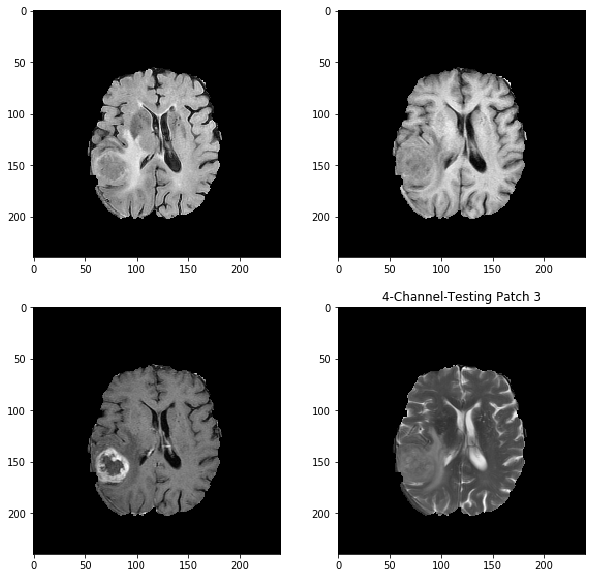

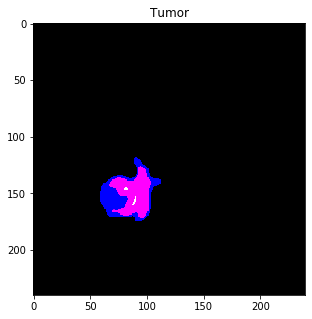

In [16]:
test_segmentation(3)    

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)
(240, 240, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


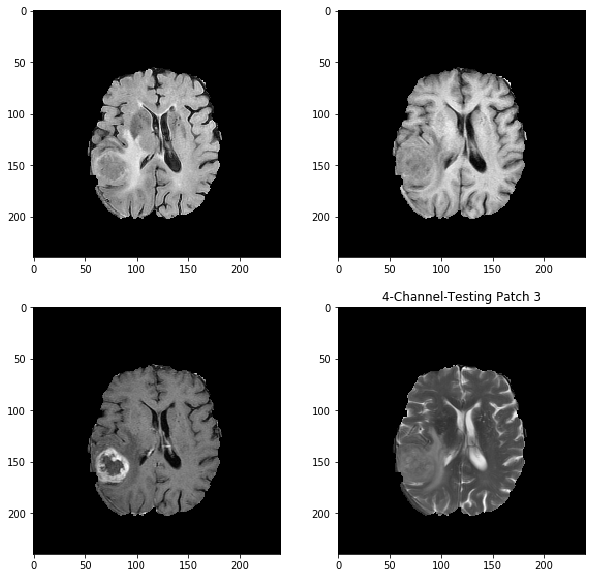

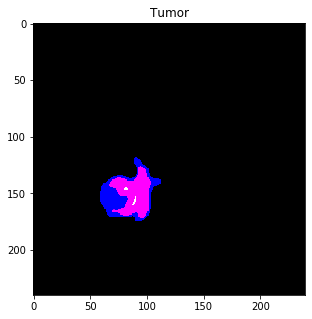

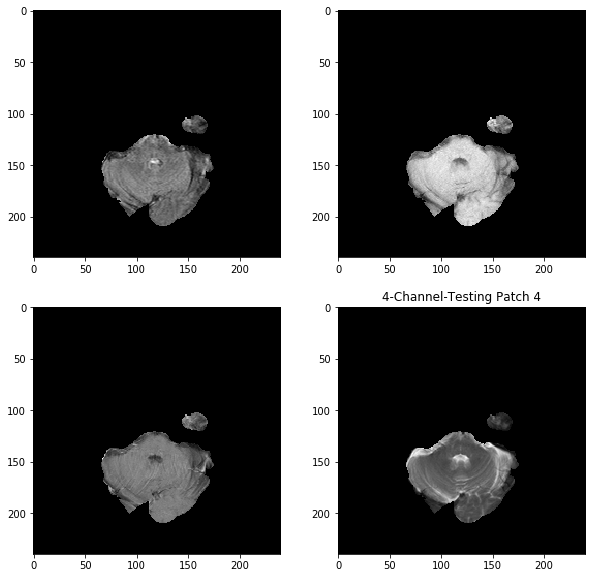

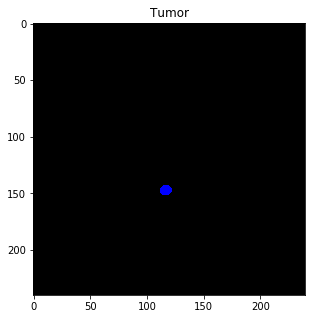

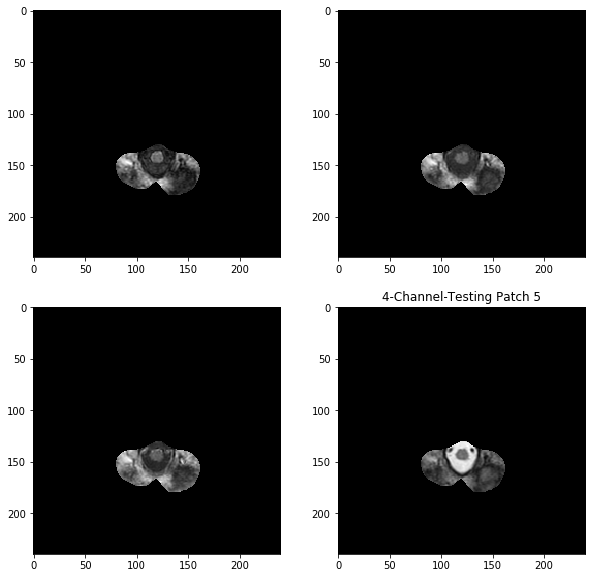

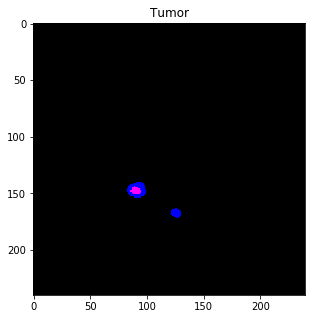

In [17]:
for i in range(3):
    test_segmentation(i+3)